Library


In [143]:
import os
import math

import numpy as np
import scipy.signal
import scipy.fftpack
from scipy.signal import resample_poly

import librosa
import soundfile as sf

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import joblib

import matplotlib.pyplot as plt

Path


In [144]:
PATH_MAIN = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# PATH_MAIN = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

PATH_DATASET = f"{PATH_MAIN}/Dataset"
PATH_MODEL = f"{PATH_MAIN}/Model"

Konstanta


In [145]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Random Seed


In [146]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Pra-Pemrosesan


In [147]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [148]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

# Visualization


In [149]:
def plot_audio_with_loud_segments(audio_path, list_result):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    
    time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
    
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(os.path.basename(audio_path))
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    for i in range(0, len(list_result)):
        start_time = list_result[i][1][0]
        end_time = list_result[i][1][1]
        if list_result[i][0] == 2:
            plt.axvspan(start_time, end_time, color='blue', alpha=0)
        elif list_result[i][0] == 1:
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)
        elif list_result[i][0] == 0:
            plt.axvspan(start_time, end_time, color='green', alpha=0.3)
    
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Load Scaler dan Model


## Scaler


In [150]:
# Scaler Pra-Klasifikasi
p_scl = joblib.load(PATH_MODEL + "/p_scaler.pkl")

# Scaler Klasifikasi
k_scl = joblib.load(PATH_MODEL + "/k_scaler.pkl")

## Model Pra-Klasifikasi


Mamdani


In [151]:
rms = ctrl.Antecedent(np.linspace(-1, 8, 100), 'rms')
flatness = ctrl.Antecedent(np.linspace(-1, 4, 100), 'flatness')
label = ctrl.Consequent(np.linspace(1, 2, 100), 'label')

rms['low'] = fuzz.trapmf(rms.universe, [-1, -1, -0.67, -0.565])
rms['medium'] = fuzz.trimf(rms.universe, [-0.67, -0.565, -0.46])
rms['high'] = fuzz.trapmf(rms.universe, [-0.565, -0.46, 8, 8])

flatness['rigid'] = fuzz.trapmf(flatness.universe, [-1, -1, -0.45, -0.35])
flatness['smooth'] = fuzz.trapmf(flatness.universe, [-0.45, -0.35, 4, 4])

label['event'] = fuzz.trimf(label.universe, [1, 1, 1])
label['nonevent'] = fuzz.trimf(label.universe, [2, 2, 2])

rule1 = ctrl.Rule(flatness['smooth'] & rms['low'], label['nonevent'])
rule2 = ctrl.Rule(flatness['smooth'] & rms['medium'], label['nonevent'])
rule3 = ctrl.Rule(flatness['smooth'] & rms['high'], label['event'])
rule4 = ctrl.Rule(flatness['rigid'] & rms['low'], label['nonevent'])
rule5 = ctrl.Rule(flatness['rigid'] & rms['medium'], label['nonevent'])
rule6 = ctrl.Rule(flatness['rigid'] & rms['high'], label['event'])

mamdani_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

def fuzzy_inference(rms_value, flatness_value):
    system = ctrl.ControlSystemSimulation(mamdani_ctrl)
    try:
        system.input['rms'] = np.clip(rms_value, -1, 1)
        system.input['flatness'] = np.clip(flatness_value, -1, 1)
        system.compute()
        return system.output['label']
    except KeyError:
        return 1.5

def p_mamdani(X):
    y_pred = []
    for data in X:
        output = fuzzy_inference(data[0], data[1])
        predicted_class = int(round(output))
        y_pred.append(predicted_class)
    return np.array(y_pred)

Supervised


In [152]:
# Logistic Regression
p_lr = joblib.load(PATH_MODEL + "/p_lr.pkl")

# Descision Tree
p_dt = joblib.load(PATH_MODEL + "/p_dt.pkl")

# LGBM Classifier
p_lgbm = joblib.load(PATH_MODEL + "/p_lgbm.pkl")

## Model Klasifikasi


Supervised


In [153]:
# LGBM
k_lgbm = joblib.load(PATH_MODEL + "/k_lgbm.pkl")

# CNN
k_mlp = joblib.load(PATH_MODEL + "/k_mlp.pkl")

# Main


## Single Audio Inference


In [154]:
def single_inference(path):
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)
    
    list_result = []
    time = 0
    for segment in segments:
        timestamp = [time * 0.5, (time*0.5) + 1]
        time += 1
        
        rms = get_rms(segment)
        flatness = get_spectral_flatness(segment)
        rms_scaled, flatness_scaled = p_scl.transform([[rms, flatness]])[0]
        label = p_mamdani([[rms_scaled, flatness_scaled]])
        # label = p_sugeno([[rms_scaled, flatness_scaled]])
        # label = p_lr.predict([[rms_scaled, flatness_scaled]])[0]
        # label = p_dt.predict([[rms_scaled, flatness_scaled]])[0]
        # label = p_lgbm.predict([[rms_scaled, flatness_scaled]])[0]

        if label != 2:
            mfcc = get_mfcc(segment)
            mfcc = np.array(mfcc)
            mfcc = mfcc.reshape(1, -1)
            mfcc_scaled = k_scl.transform(mfcc)
            # label = k_lgbm.predict(mfcc_scaled)[0]
            label = k_mlp.predict(mfcc_scaled)[0]
        
        list_result.append([label, timestamp])
    
    return list_result

# Execution


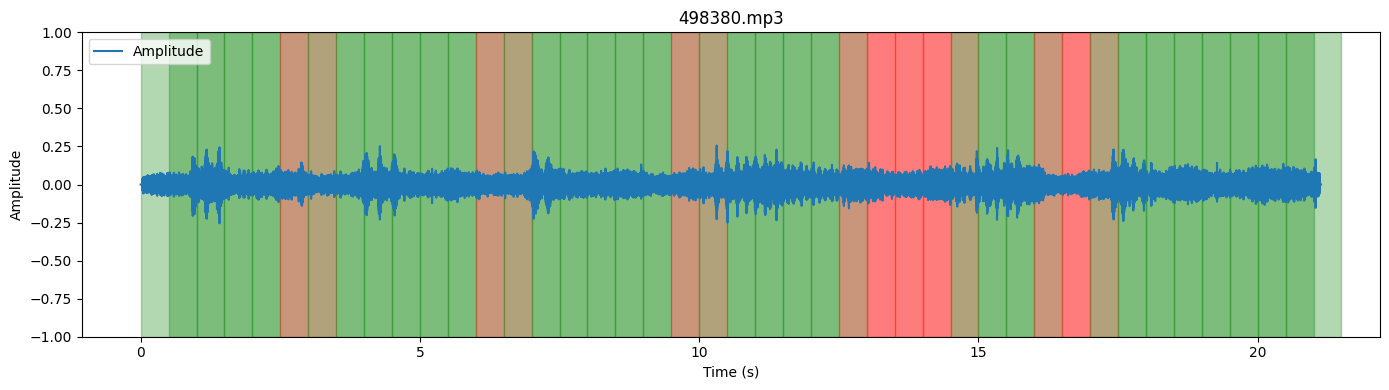

In [155]:
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data\1-7974-B-49.wav"
audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto\498380.mp3"

hasil_inferensi = single_inference(audio_path)
plot_audio_with_loud_segments(audio_path, hasil_inferensi)

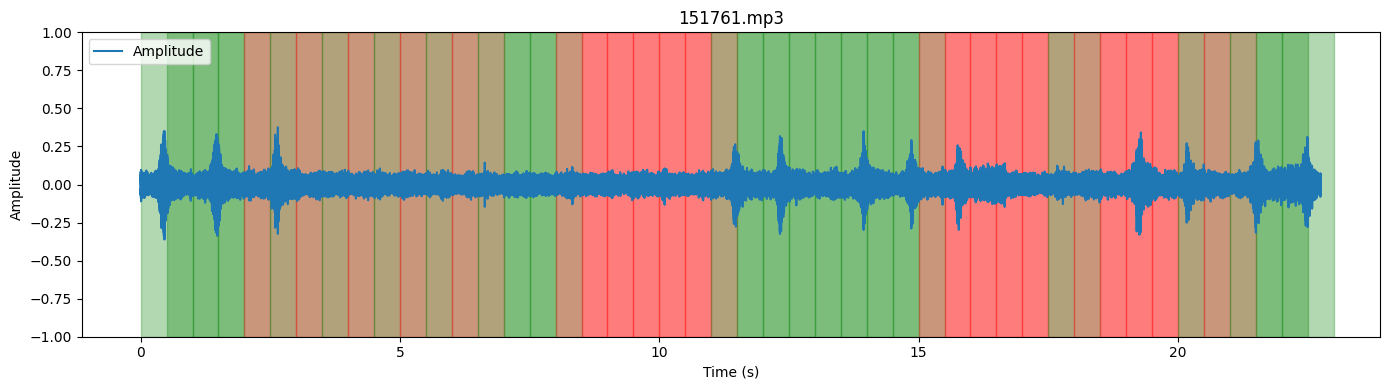

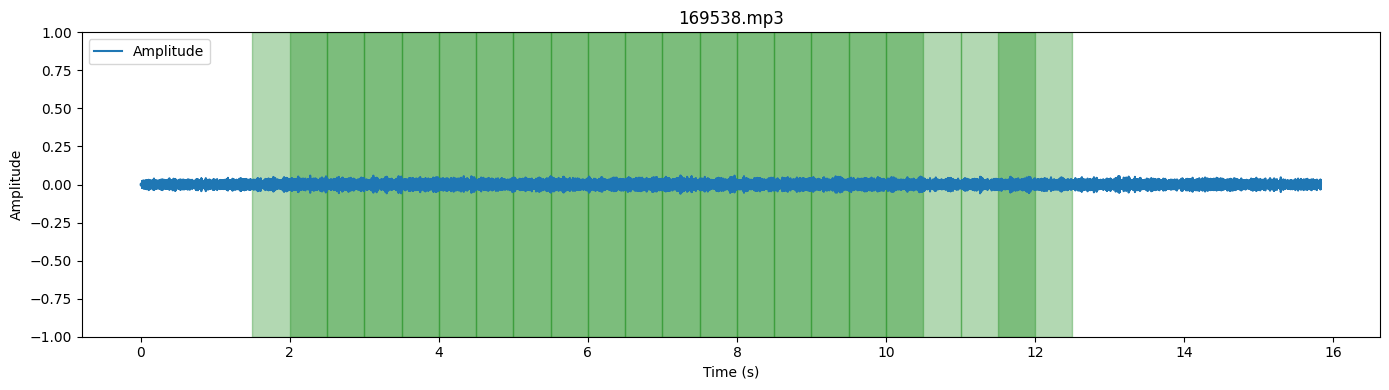

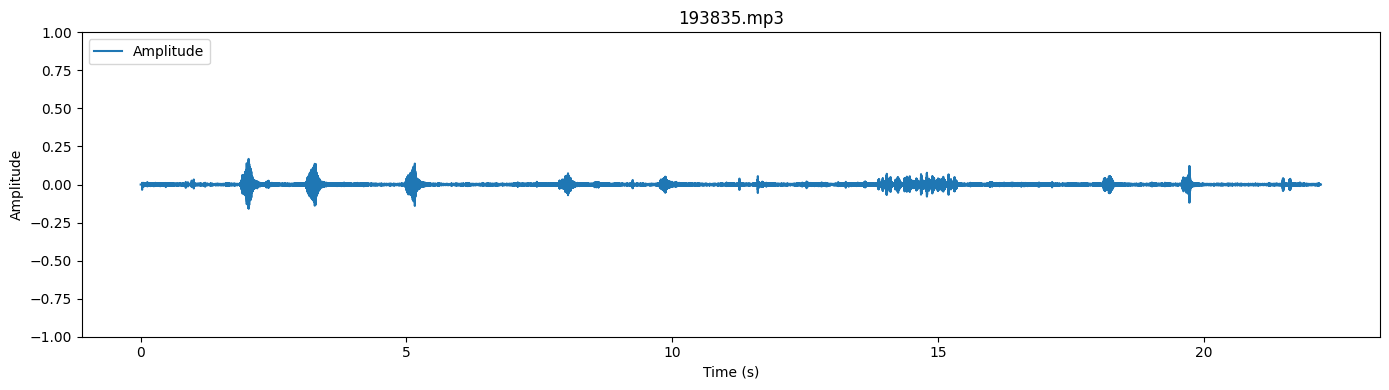

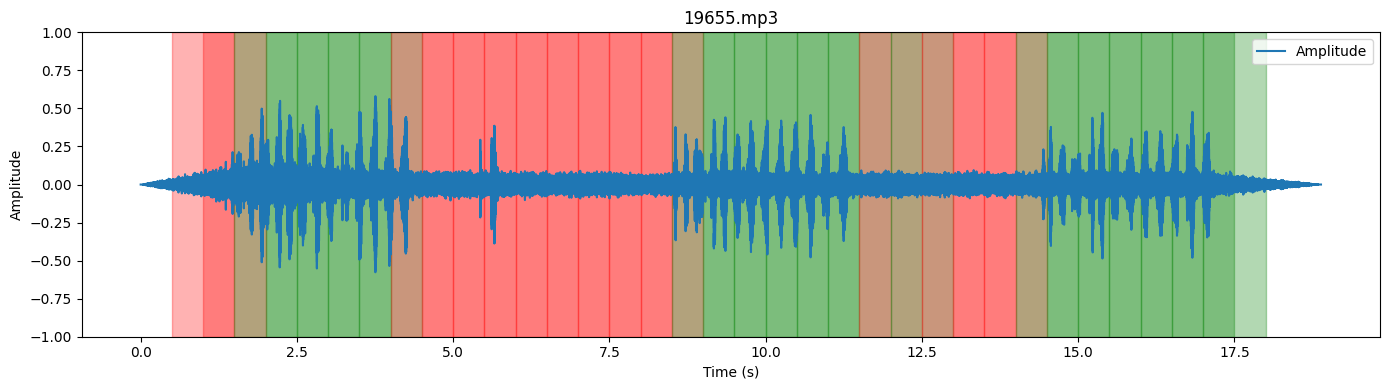

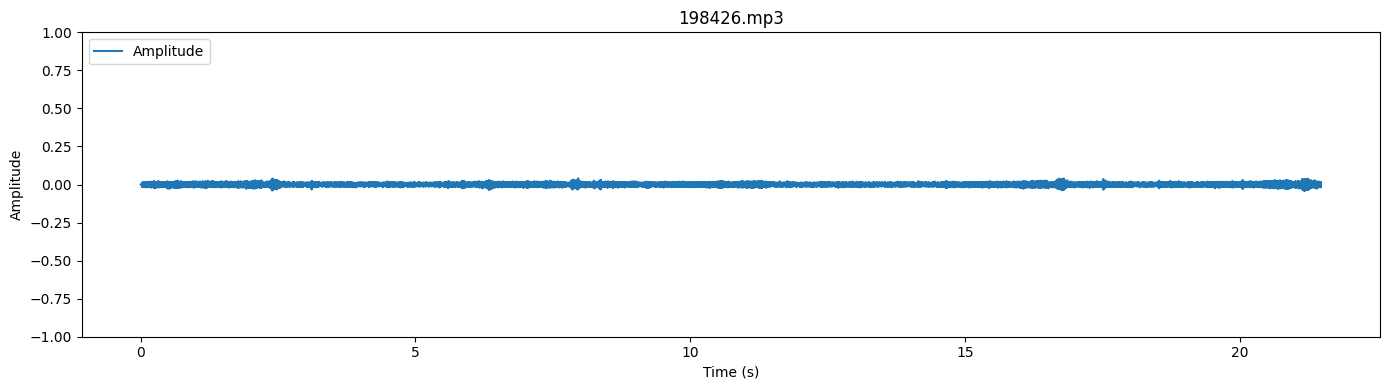

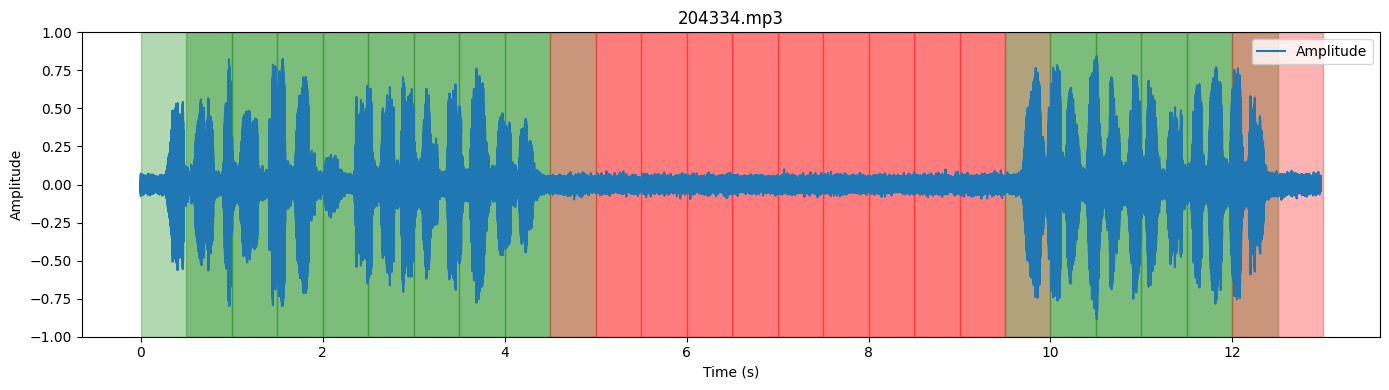

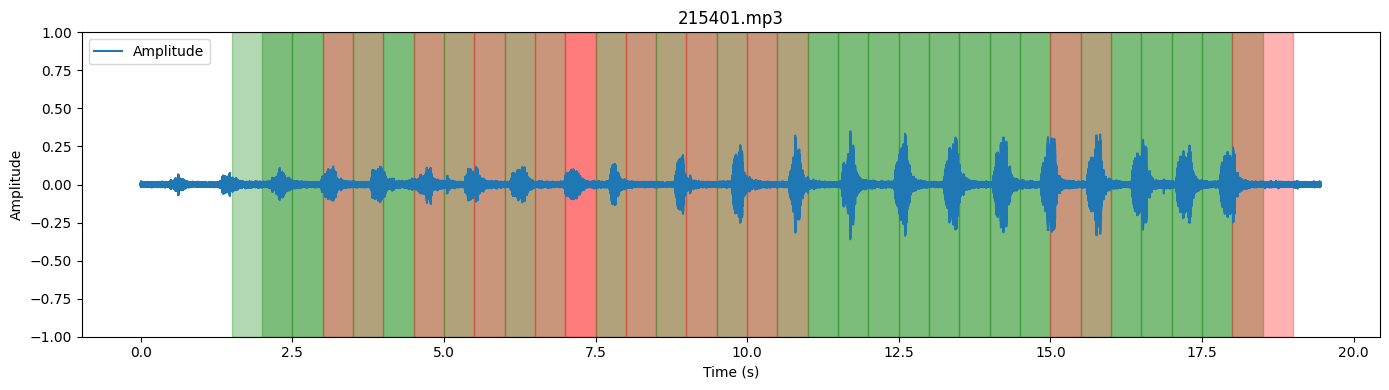

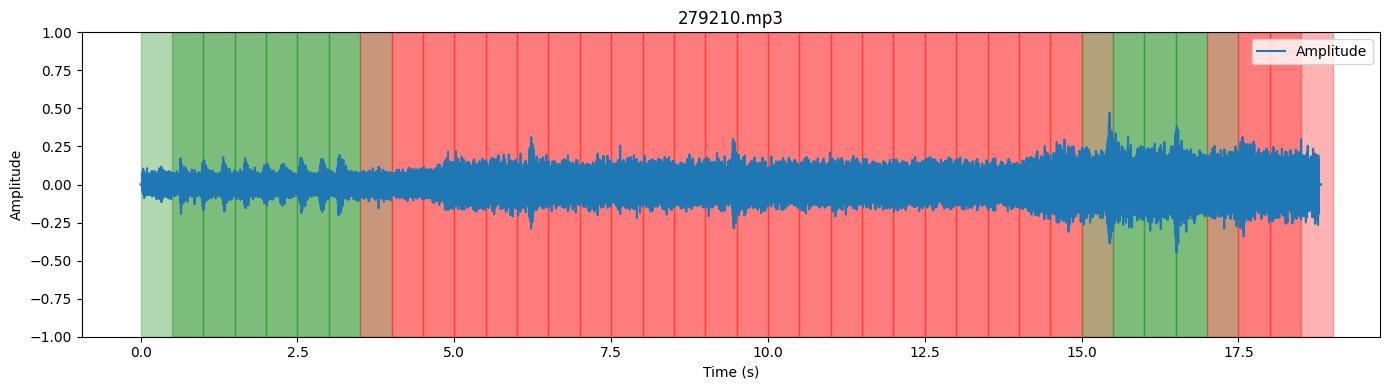

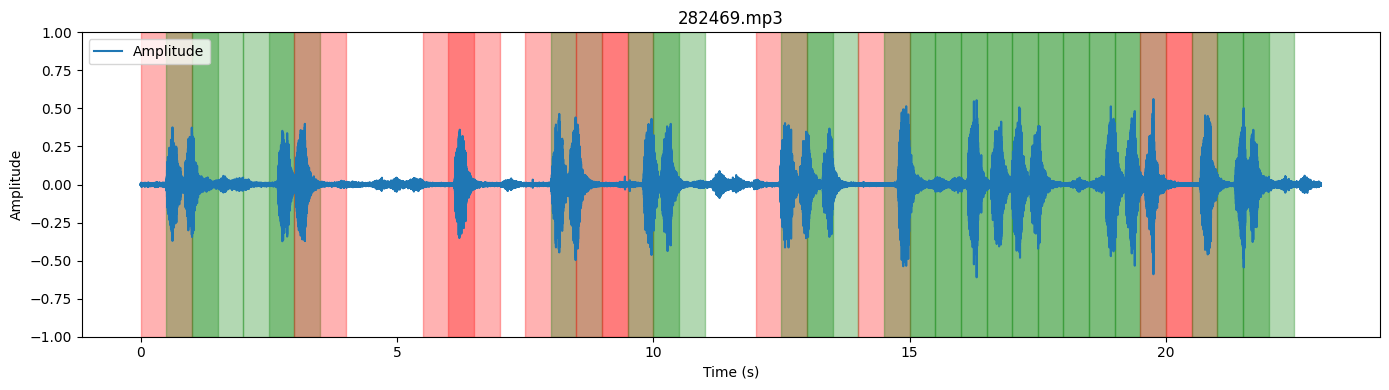

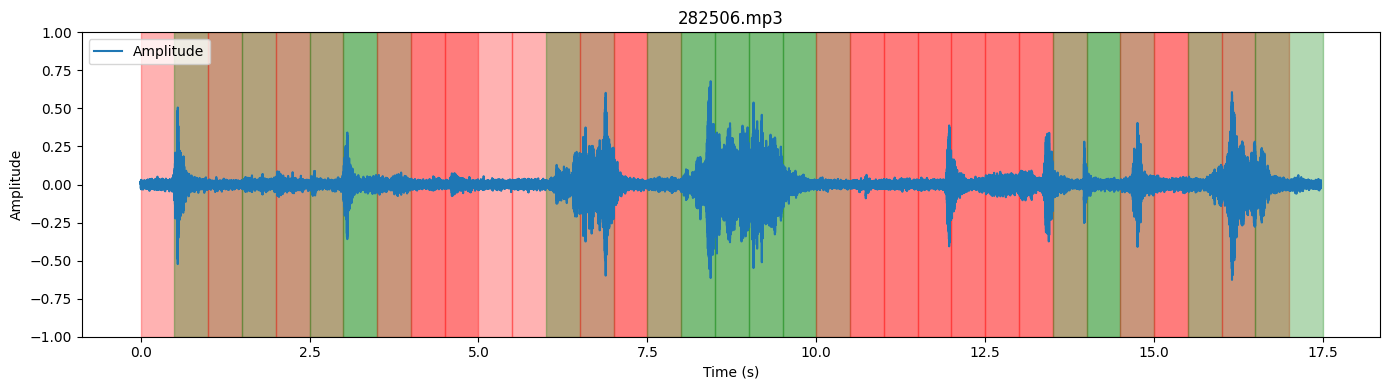

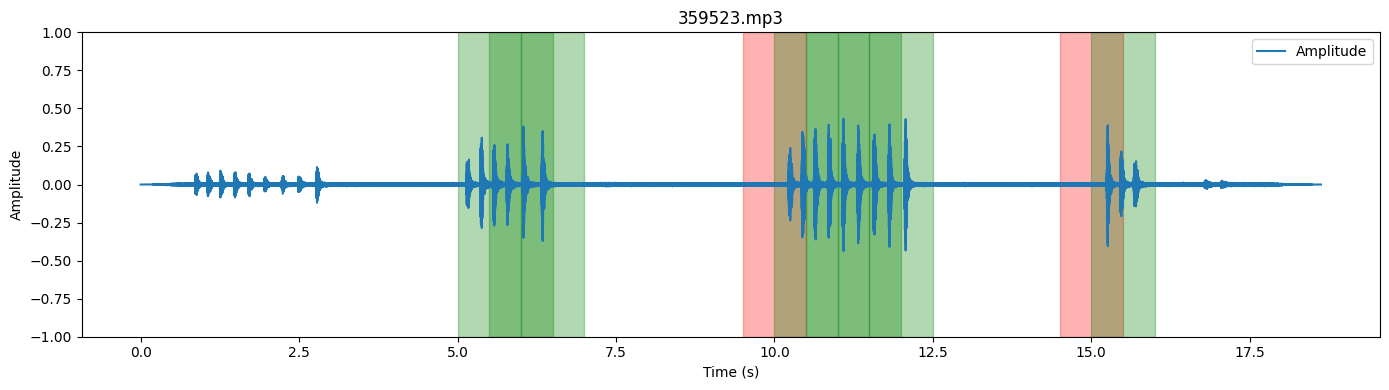

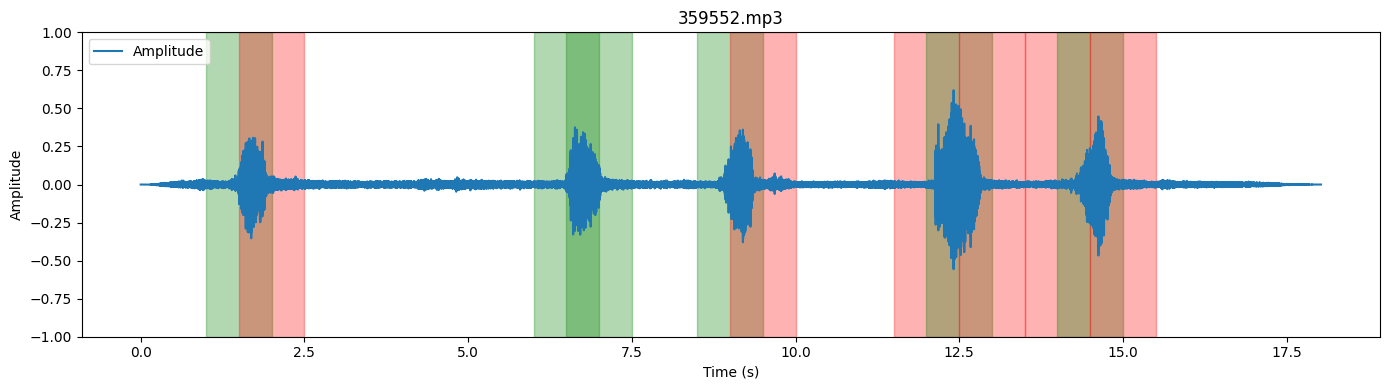

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


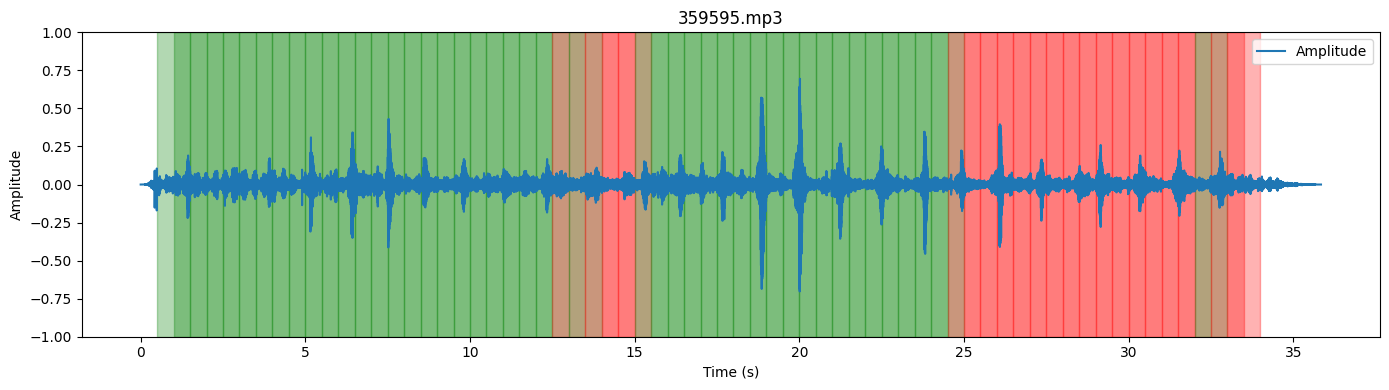

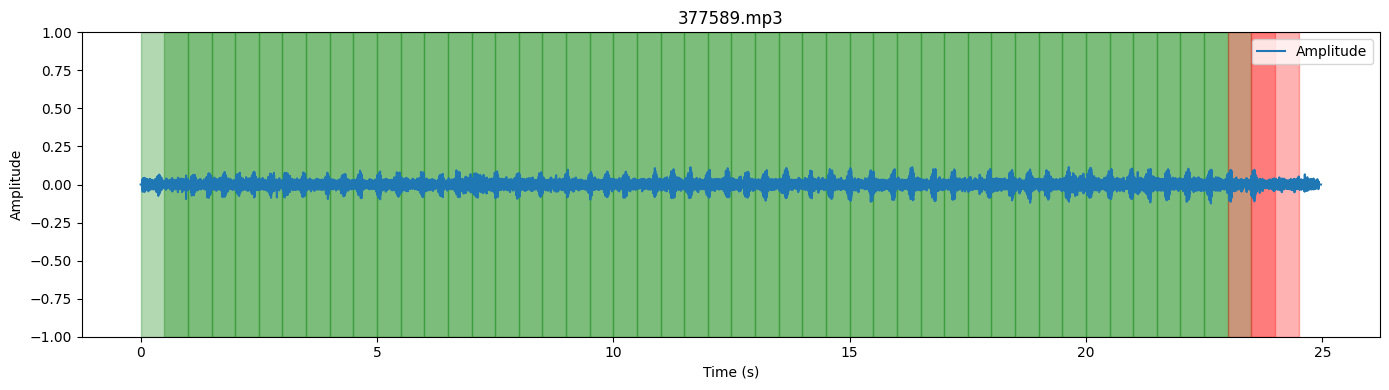

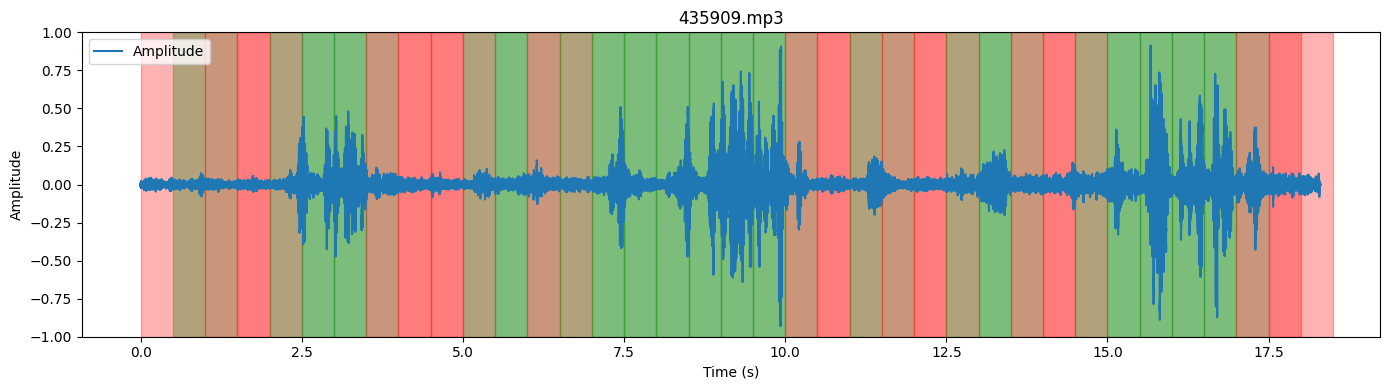

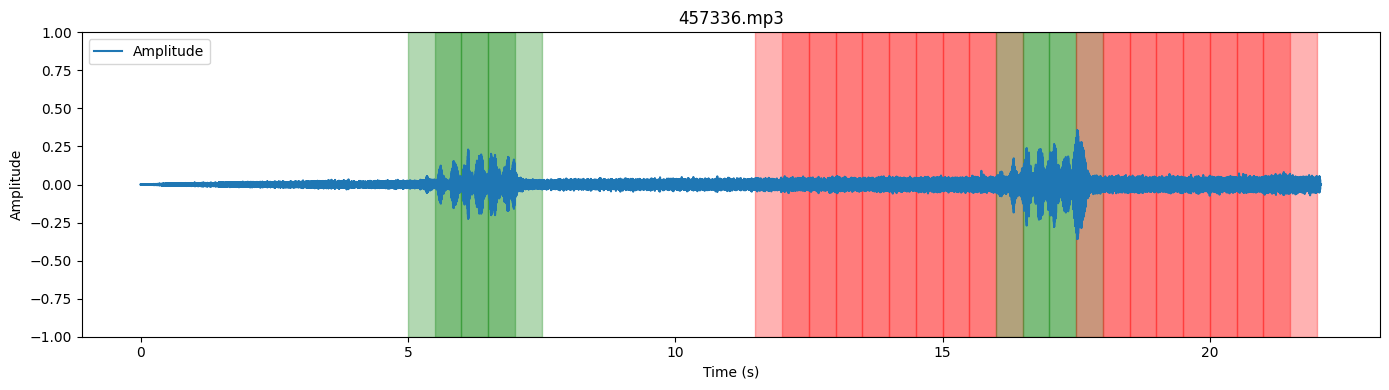

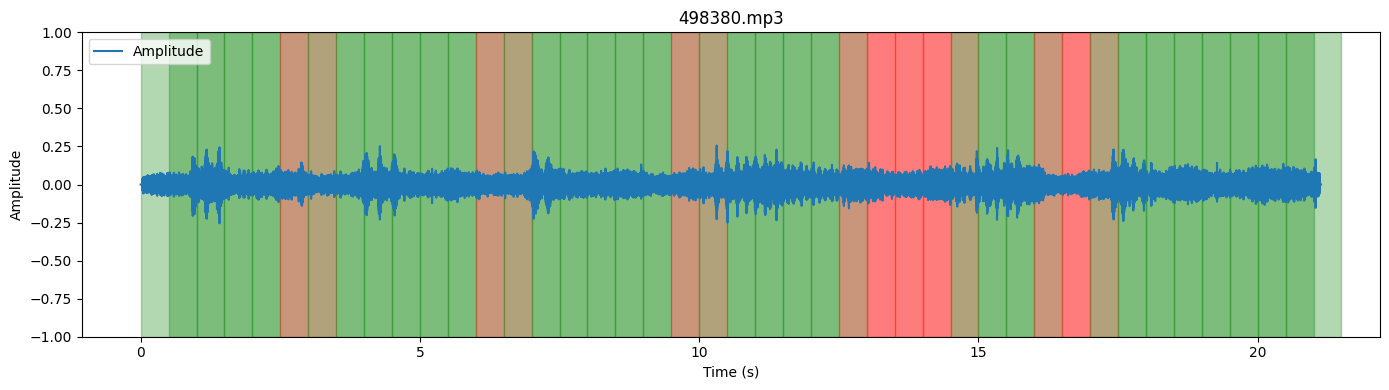

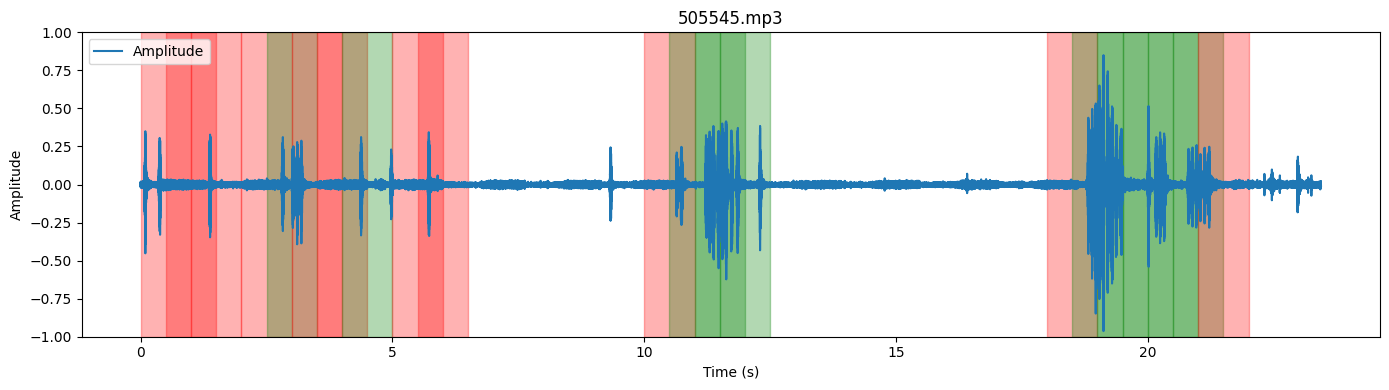

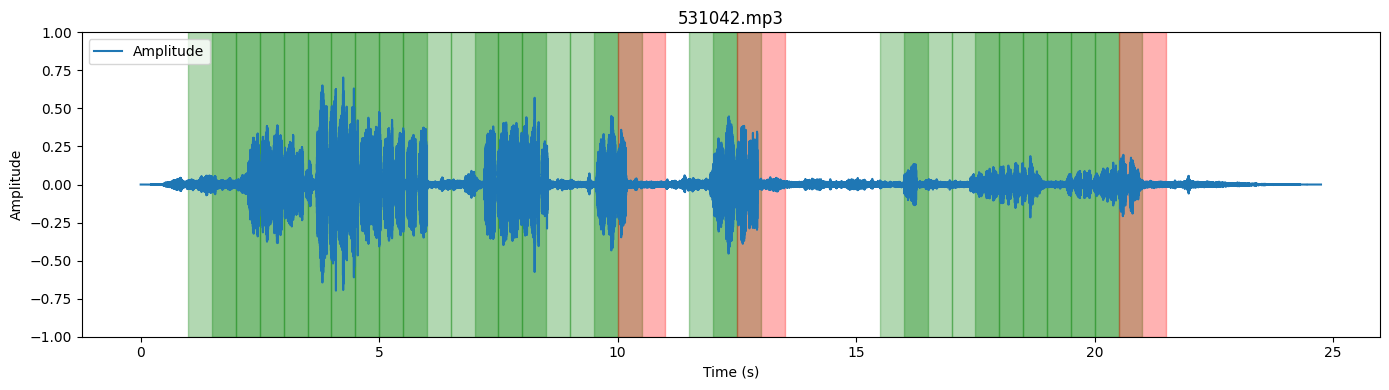

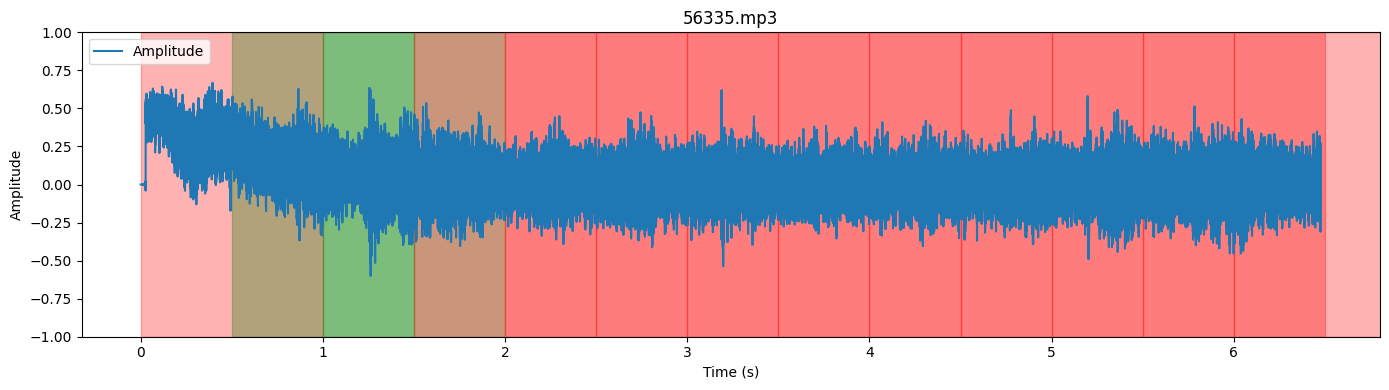

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


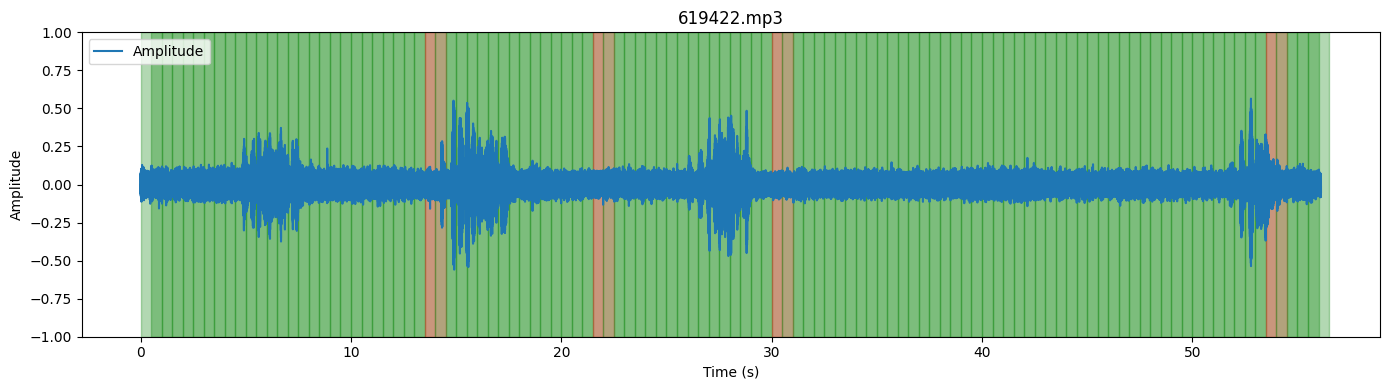

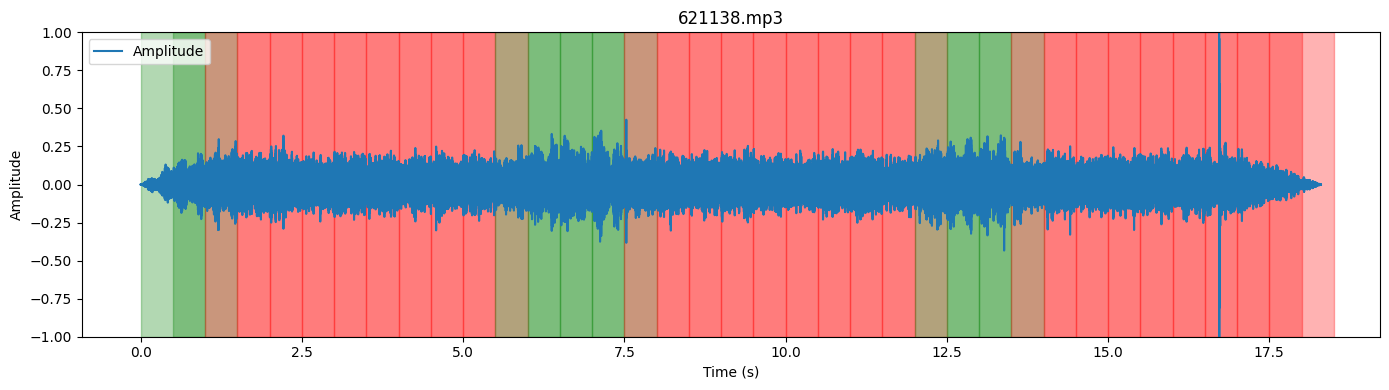

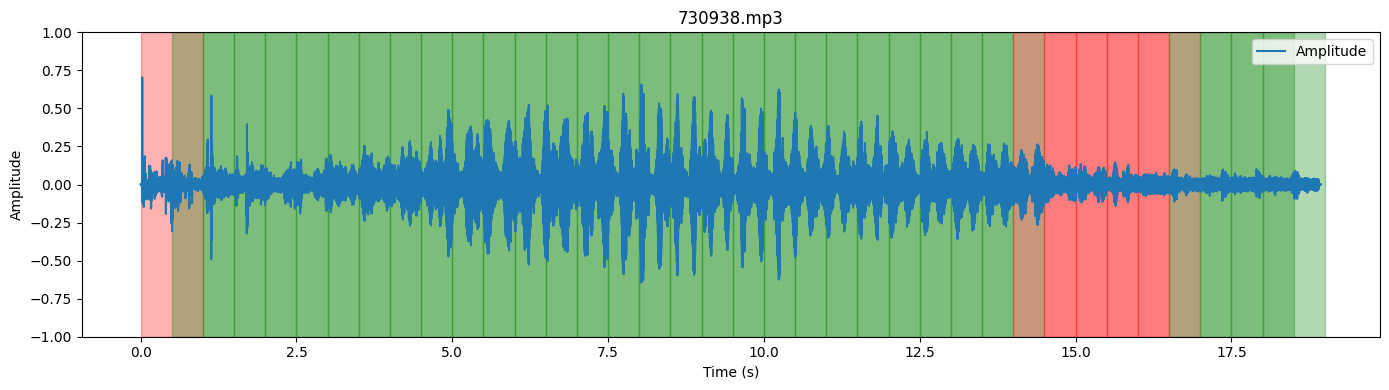

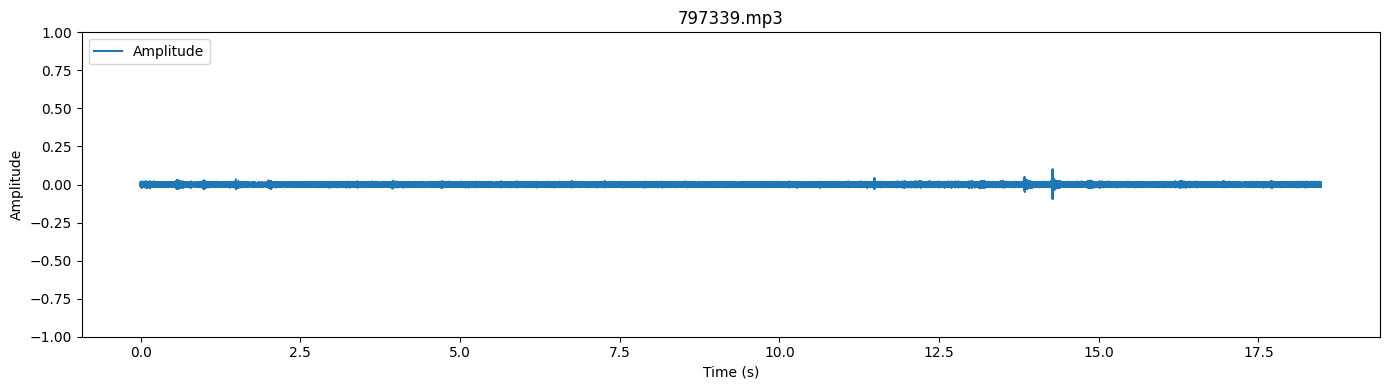

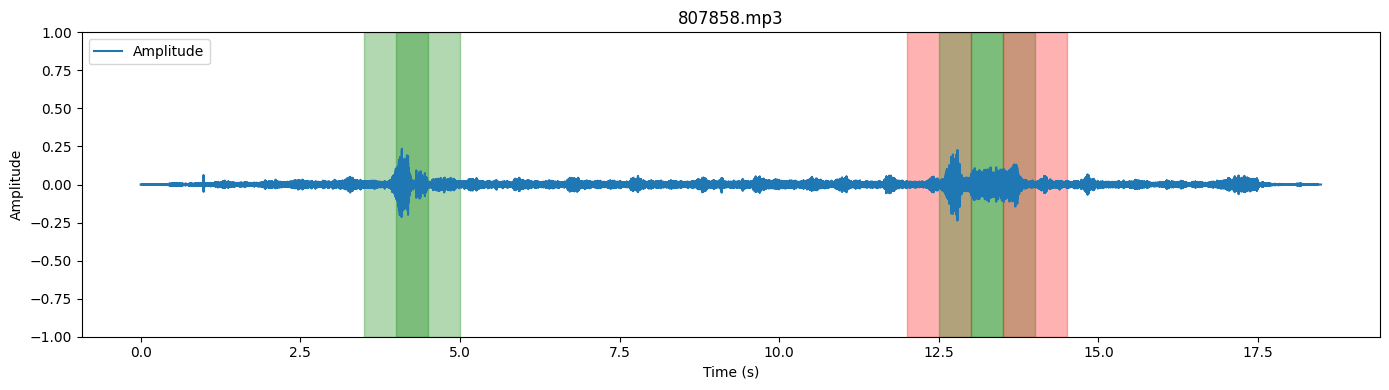

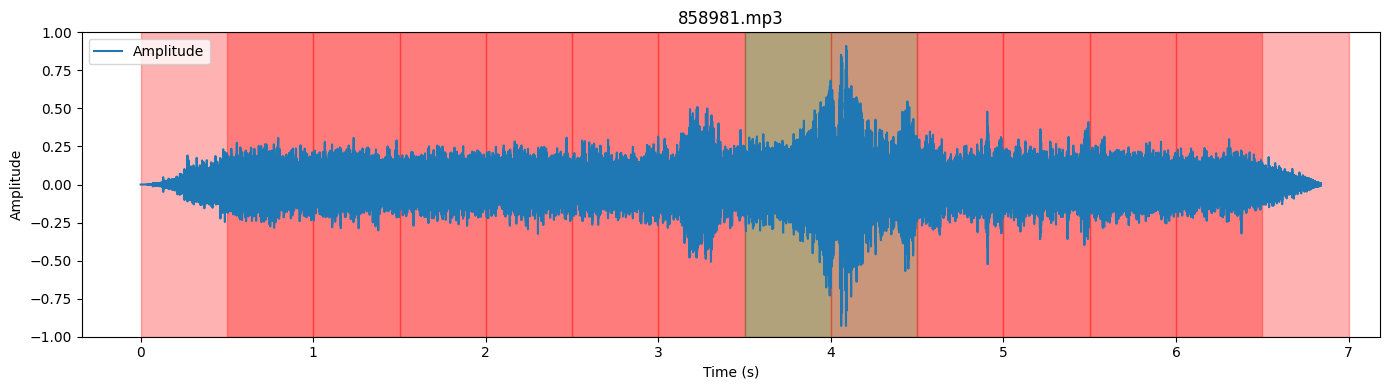

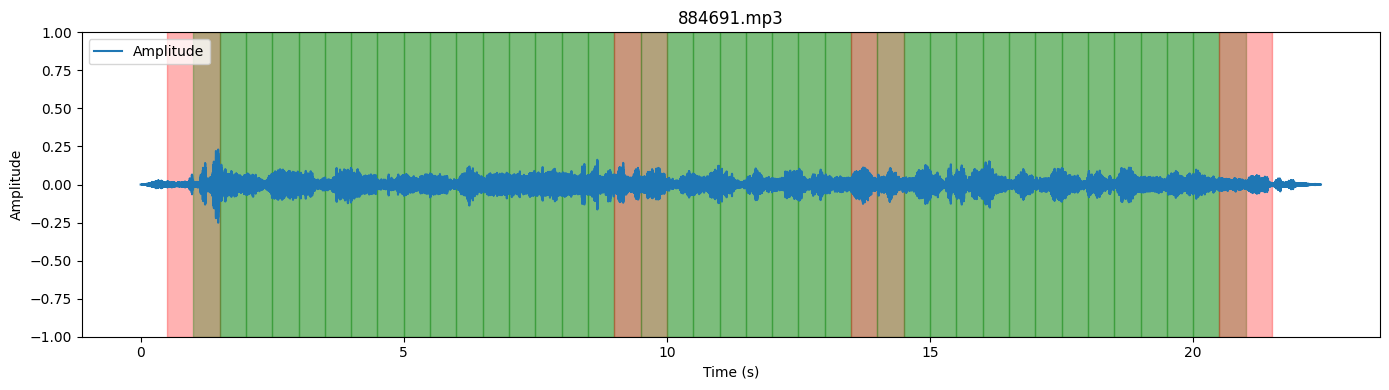

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


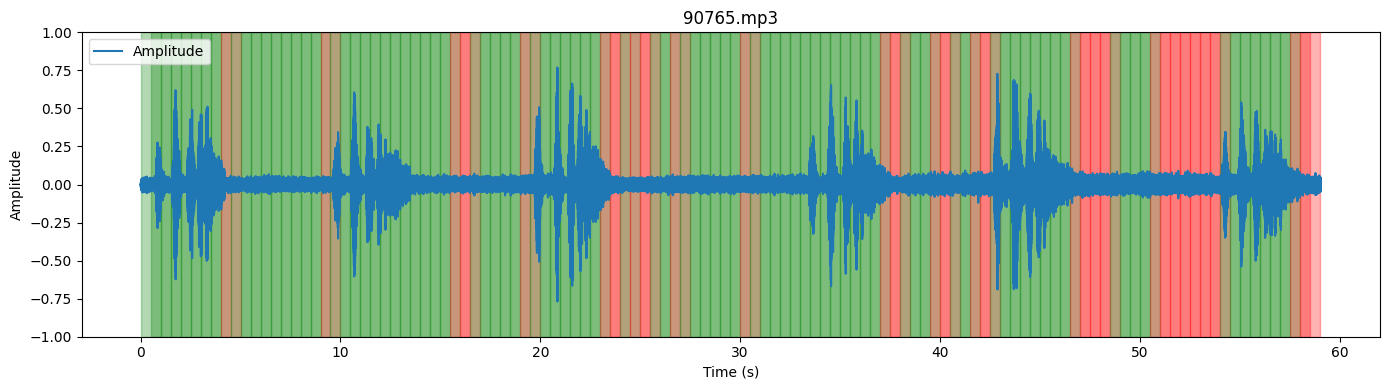

KeyboardInterrupt: 

In [156]:
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data"
audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto"

for file in os.listdir(audio_path):
    hasil_inferensi = single_inference(f"{audio_path}/{file}")
    plot_audio_with_loud_segments(f"{audio_path}/{file}", hasil_inferensi)